# Fraudulent Transaction Detection with Neural Networks

In [1]:
#Import Libraires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2 
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from dataclasses import replace
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
#Read CSV file to access data
DF = pd.read_csv('Final Transactions.csv')

# Data Engeneering

### Data Cleaning  

In [3]:
#Get dtype info from df
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754155 entries, 0 to 1754154
Data columns (total 10 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Unnamed: 0         int64  
 1   TRANSACTION_ID     int64  
 2   TX_DATETIME        object 
 3   CUSTOMER_ID        int64  
 4   TERMINAL_ID        int64  
 5   TX_AMOUNT          float64
 6   TX_TIME_SECONDS    int64  
 7   TX_TIME_DAYS       int64  
 8   TX_FRAUD           int64  
 9   TX_FRAUD_SCENARIO  int64  
dtypes: float64(1), int64(8), object(1)
memory usage: 133.8+ MB


Change DataType for TX_DATETIME

In [4]:
#Change Datatype of column
DF.TX_DATETIME= pd.to_datetime(DF.TX_DATETIME)
print(DF.TX_DATETIME.head(3))

0   2023-01-01 00:00:31
1   2023-01-01 00:02:10
2   2023-01-01 00:07:56
Name: TX_DATETIME, dtype: datetime64[ns]


### Feature Engeneering



In [6]:
# FUNCTION DROPS COLUMNS FROM DF 

    ## *col represents a variable number of arguments
def drop_from_df(dataframe,*col):
    ## *col arguments return tuples therefore list(col) converts the items into a list.
    dataframe = dataframe.drop(columns= list(col))
    return dataframe

# ADJUST DF TO DROPPED COLUMNS
DF = drop_from_df(DF,'Unnamed: 0','CUSTOMER_ID','TRANSACTION_ID','TX_FRAUD_SCENARIO')

Filter column for outliers

In [7]:
#Decribe statistical instances from variables.
DF.describe()

,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD
count,1.754155e+06,1.754155e+06,1.754155e+06,1.754155e+06,1.754155e+06
mean,4.996733e+03,5.396820e+02,7.903234e+06,9.097260e+01,1.345200e-01
std,2.886101e+03,1.179711e+03,4.565172e+06,5.283709e+01,3.412103e-01
min,0.000000e+00,0.000000e+00,3.100000e+01,0.000000e+00,0.000000e+00
25%,2.502000e+03,1.799500e+02,3.940846e+06,4.500000e+01,0.000000e+00
50%,4.994000e+03,4.217500e+02,7.902670e+06,9.100000e+01,0.000000e+00
75%,7.495000e+03,7.505950e+02,1.186566e+07,1.370000e+02,0.000000e+00
max,9.999000e+03,6.478375e+05,1.581120e+07,1.820000e+02,1.000000e+00


In [8]:
#   Creating the same function without the use of Global-Variables
def filter_rows(list,DF):
    for i in list:
        DF = DF[DF[i] <= DF[i].quantile(.75)]
    DF.reset_index(drop = True , inplace=True)
    return DF

DF = filter_rows(['TX_AMOUNT'],DF)

In [9]:
# Change the datetime format using the strftime method
DF['Month'] = DF['TX_DATETIME'].apply(lambda x: x.strftime('%m')).astype(int)
DF['DoW'] = DF['TX_DATETIME'].apply(lambda x: pd.Timestamp(x).dayofweek+1)
DF['AM_PM'] = DF['TX_DATETIME'].apply(lambda x: x.strftime('%H')).astype(int)

# ADJUST DF TO DROPPED COLUMNS
DF = drop_from_df(DF,'TX_DATETIME')

In [10]:
#changing to 1 if value is PM and 0 if AM
DF['AM_PM'] = [1 if i >= 13 else 0 for i in DF['AM_PM']]

In [11]:
DF.head()

,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,Month,DoW,AM_PM
0,3156,533.07,31,0,0,1,7,0
1,8737,620.65,569,0,0,1,7,0
2,9906,490.66,634,0,0,1,7,0
3,8803,401.17,645,0,0,1,7,0
4,2486,206.53,704,0,0,1,7,0


In [12]:
# Rearrange columns so that our Y is on the last column
DF = DF.iloc[:,[0,1,2,3,5,6,7,4]]

### EDA

Month
1    71116843.29
2    64297651.04
3    70671381.44
4    68666660.19
5    70811932.44
6    68844223.55
7     4478147.20
Name: TX_AMOUNT, dtype: float64


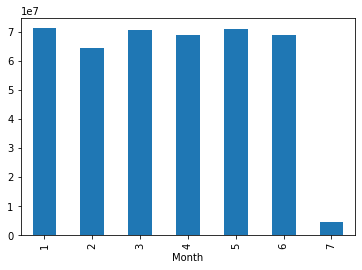

In [14]:
# Group the data by date and sum the sales for each date
DF['TX_AMOUNT'].groupby(DF['Month']).sum().plot(kind='bar')
print(DF['TX_AMOUNT'].groupby(DF['Month']).sum())

DoW
1    59681940.65
2    59457513.18
3    59433587.51
4    59665089.39
5    59222416.90
6    59420990.73
7    62005300.79
Name: TX_AMOUNT, dtype: float64


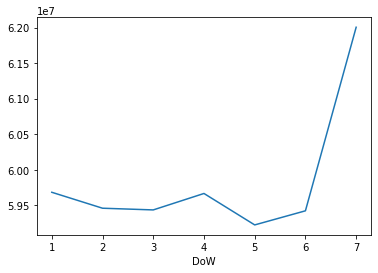

In [15]:
# Display the sum of the transasaction amount per day of the week 
DF['TX_AMOUNT'].groupby(DF['DoW']).sum().plot(kind='line')
print(DF['TX_AMOUNT'].groupby(DF['DoW']).sum())

AM_PM
0    4050
1    2981
Name: TX_FRAUD, dtype: int64


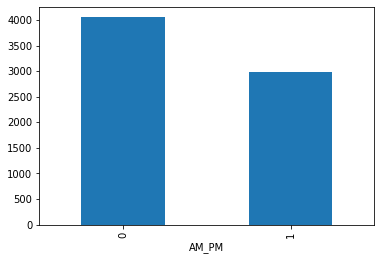

In [16]:
#Displays if Fraudulent transactions where made during AM hours (0) or PM hours (1)
DF.TX_FRAUD[DF.TX_FRAUD == 1].groupby(DF['AM_PM']).count().plot(kind='bar')
print(DF.TX_FRAUD[DF.TX_FRAUD == 1].groupby(DF['AM_PM']).count())

<AxesSubplot:xlabel='DoW'>

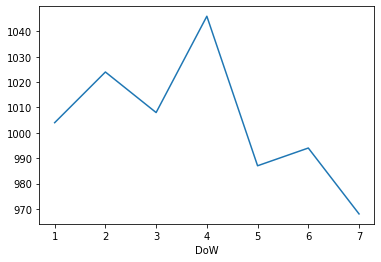

In [17]:
#Return DF TX_FRAUD where TX_FRAUD == 1 and group by DoW plot.
DF.TX_FRAUD[DF.TX_FRAUD == 1].groupby(DF.DoW).count().plot(kind='line')

#### Feature Selection 

In [18]:
#Eliminating Correlated Features
DF.corr().abs()

,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,Month,DoW,AM_PM,TX_FRAUD
TERMINAL_ID,1.000000,0.001447,0.000638,0.000635,0.000811,0.000243,0.001091,0.007142
TX_AMOUNT,0.001447,1.000000,0.000755,0.000752,0.000655,0.000291,0.000014,0.003040
TX_TIME_SECONDS,0.000638,0.000755,1.000000,0.999992,0.986055,0.025165,0.003969,0.009998
TX_TIME_DAYS,0.000635,0.000752,0.999992,1.000000,0.986063,0.025164,0.000736,0.010004
Month,0.000811,0.000655,0.986055,0.986063,1.000000,0.030235,0.000644,0.009247
DoW,0.000243,0.000291,0.025165,0.025164,0.030235,1.000000,0.000885,0.001578
AM_PM,0.001091,0.000014,0.003969,0.000736,0.000644,0.000885,1.000000,0.000361
TX_FRAUD,0.007142,0.003040,0.009998,0.010004,0.009247,0.001578,0.000361,1.000000


In [19]:
#Removing TX_TIME_SECONDS	& TX_TIME_DAYS from DF because they are highly correlated
DF = DF[['TERMINAL_ID','TX_AMOUNT','Month','DoW','AM_PM','TX_FRAUD']]

In [20]:
DF.head()

,TERMINAL_ID,TX_AMOUNT,Month,DoW,AM_PM,TX_FRAUD
0,3156,533.07,1,7,0,0
1,8737,620.65,1,7,0,0
2,9906,490.66,1,7,0,0
3,8803,401.17,1,7,0,0
4,2486,206.53,1,7,0,0


In [21]:
X = DF.iloc[:,0:-1]
y = DF.iloc[:,-1:]

In [22]:
print(X.shape)

(1315616, 5)


In [23]:
# Select K-best 
X_new = SelectKBest(chi2,k=4)
X_new.fit(X,y)
X_new.transform(X).shape
X.columns[X_new.get_support()]

Index(['TERMINAL_ID', 'TX_AMOUNT', 'Month', 'DoW'], dtype='object')

In [24]:
# Set new DF with our Best selected featues from the step above 
DF = DF[['TERMINAL_ID', 'TX_AMOUNT', 'Month', 'DoW','TX_FRAUD']]
DF.shape

(1315616, 5)

# Modeling

In [25]:
#Define our variables of input(X) and the variable we intend to predict(Y)
X = DF.iloc[:,0:4]
y = DF.iloc[:,-1]

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=32)

In [27]:
#Normalizing features with Standard Scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(X_train)
x_test = scaler.transform(X_test)

In [28]:
print('X shape:{0}, y shape:{1}'.format(X.shape, y.shape))
print('X_train shape:{0}, y_train shape:{1}'.format(X_train.shape,y_train.shape))
print('X_test shape:{0}, y_test shape:{1}'.format(X_test.shape, y_test.shape))

X shape:(1315616, 4), y shape:(1315616,)
X_train shape:(986712, 4), y_train shape:(986712,)
X_test shape:(328904, 4), y_test shape:(328904,)


### Neural Network

In [29]:
# Step one : Model Architecture
inputs = keras.Input(shape=(4, ), name='input_layer')

## First hidden layer
l_1 = layers.Dense(3, activation='relu',name='l_1')(inputs)
l_1 = layers.BatchNormalization()(l_1)
l_1 = layers.Dropout(0.4)(l_1)

## output layer
outputs = layers.Dense(1, activation='sigmoid',name='output_layer')(l_1)
                       
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 4)]               0         
                                                                 
 l_1 (Dense)                 (None, 3)                 15        
                                                                 
 batch_normalization (BatchN  (None, 3)                12        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 3)                 0         
                                                                 
 output_layer (Dense)        (None, 1)                 4         
                                                                 
Total params: 31
Trainable params: 25
Non-trainable params: 6
_________________________________________________________________

2023-05-25 17:32:22.366756: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [30]:
# Step 3: Model Compilation
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [31]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Step 4: Model Training
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
model.fit(X_train, y_train, epochs=3, batch_size=60, validation_split=0.2,callbacks=[tensorboard_callback])

Epoch 1/3
13157/13157 [==============================] - 13s 946us/step - loss: 0.0690 - accuracy: 0.9928 - val_loss: 0.0328 - val_accuracy: 0.9948
Epoch 2/3
13157/13157 [==============================] - 12s 921us/step - loss: 0.0341 - accuracy: 0.9946 - val_loss: 0.0328 - val_accuracy: 0.9948
Epoch 3/3
13157/13157 [==============================] - 12s 907us/step - loss: 0.0338 - accuracy: 0.9946 - val_loss: 0.0328 - val_accuracy: 0.9948



Based on the output of your model, it appears that your model is not overfitting. The training loss and validation loss are both decreasing, which means that the model is learning the patterns in the data and is able to generalize to new data.

The model is also not too simple, as it has 13157 parameters. This is a large enough number of parameters to learn the patterns in the data.

The model is being trained for 50 epochs, which is a long enough time to learn the patterns in the data.

The model is using the Adam optimizer, which is a good optimizer for deep learning models.

Therefore, it is likely that the reason why your val_loss is not changing is because your model has reached a plateau. This means that the model has learned as much as it can from the training data, and is not able to improve its performance any further.

There are a few things you can do to try to improve the performance of your model:

Increase the size of your training dataset. This will give the model more data to learn from, and may help it to improve its performance.
Use a different optimizer. Some optimizers, like SGD with momentum, may be able to help the model to escape from a plateau.
Add more layers to your model. This will make your model more complex, and may help it to learn the patterns in the data better.
Use a regularization technique. Regularization techniques, like L1 or L2 regularization, can help to prevent overfitting, which may improve the performance of your model.
If you have tried all of these things and your model is still not performing well, then you may need to consult with a machine learning expert. They can help you to diagnose the problem and find a solution.

### Model Evaluation

In [32]:
# Step 5: Model Evaluation
scores = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", scores[0])
print("Test accuracy:", scores[1])


Test loss: 0.03242306038737297
Test accuracy: 0.994819164276123


In [35]:
# Create an instance of the Precision metric.
precision = tf.keras.metrics.Precision()

# Create an instance of the Recall metric.
recall = tf.keras.metrics.Recall()

# Get the predictions and labels from the model.
predictions = model.predict(X_test)
labels = y_test

# Update the state of the metrics.
precision.update_state(predictions, labels)
recall.update_state(predictions, labels)

# Get the precision and recall.
precision_score = precision.result()
recall_score = recall.result()

print("Precision:", precision_score)
print("Recall:", recall_score)

10279/10279 [==============================] - 6s 570us/step
Precision: tf.Tensor(1.0, shape=(), dtype=float32)
Recall: tf.Tensor(0.005180843, shape=(), dtype=float32)



The precision of 1.0 means that all of the positive predictions made by the model were correct. The recall of 0.005180843 means that only 0.5180843% of the positive instances were correctly identified by the model.

The high precision and low recall indicate that the model is good at identifying positive instances, but it is not very good at identifying negative instances. This could be due to a number of factors, such as a class imbalance in the data or a lack of training data.

To improve the recall of the model, you can try the following:

Use a balanced dataset. If the data is imbalanced, the model will be biased towards the majority class. To address this, you can use a variety of techniques, such as oversampling or undersampling the minority class.
Use more training data. The more data the model has to learn from, the better it will be at identifying both positive and negative instances.
Use a different model architecture. Some model architectures are better suited for certain tasks than others. If the model you are using is not working well, you can try a different architecture.
By following these tips, you can increase the chances of improving the recall of your model.